In [1]:
import numpy 
import os
import ast
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

#from wquantiles import quantile
from openfisca_survey_manager.utils import asof

#from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
#from openfisca_france_indirect_taxation.surveys import SurveyScenario
#from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy

from openfisca_france_indirect_taxation.examples.utils_example import df_weighted_average_grouped
from openfisca_france_indirect_taxation.almost_ideal_demand_system.utils import add_niveau_vie_decile
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Reform_carbon_tax import carbon_tax_rv
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Simulation_taxe_energie_winners_losers import (
    simulate_reformes_energie,
    run_all_elasticities)
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Graph_utils import (
    graph_CO2_emissions,
    graph_delta_CO2,
    graph_share_co2_emissions,
    graph_share_emissions_reduction,
    graph_ratio_emissions_reduction,
    graph_winners_losers,
    graph_net_transfers,
    graph_net_transfers_uc,
    graph_effort_rate,
    quantiles_for_boxplot,
    boxplot_effort_rate,
    boxplot_net_transfers,
    boxplot_net_transfers_uc
    )

In [2]:
data_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data"
output_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Output"
sns.set_style("whitegrid")

In [3]:
df_elasticities = pd.read_csv(os.path.join(data_path,'Reform_parameters/Elasticities_literature.csv'), sep = ";")
df_elasticities = df_elasticities.astype({'ref_elasticity': str, 'elas_price_1_1': float , 'elas_price_2_2' : float ,'elas_price_3_3' : float })

# exemple
elasticites_douenne = df_elasticities[df_elasticities['ref_elasticity'] == 'Douenne (2020)'] 

In [4]:
ident_men = pd.HDFStore("C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data/data_collections/output/openfisca_indirect_taxation_data_2017.h5")['input'][['ident_men','pondmen', 'rev_disponible','ocde10','strate','depenses_carburants_corrigees_entd']]
ident_men['ident_men'] = ident_men.ident_men.astype(numpy.int64)
ident_men = add_niveau_vie_decile(ident_men)

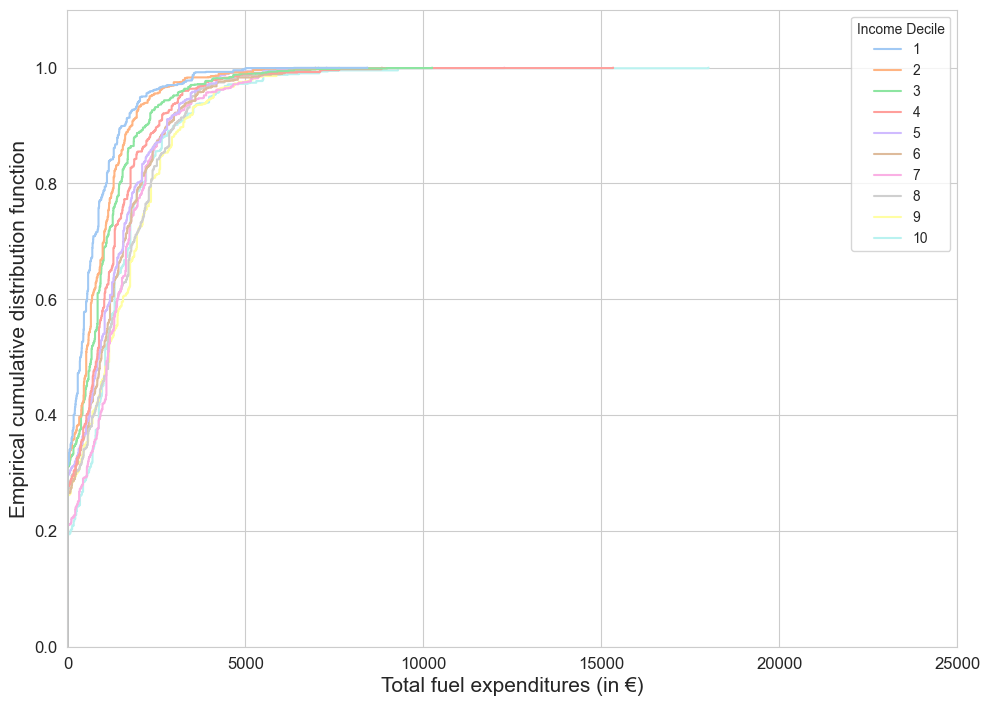

In [5]:
data = ident_men.copy()
data.rename(columns = {'niveau_vie_decile' : 'Income Decile'}, inplace = True)
data['Income Decile'] = data['Income Decile'].astype(int)
fig, ax = plt.subplots(figsize=(10, 7))
sns.ecdfplot(data=data, x='depenses_carburants_corrigees_entd', hue='Income Decile', 
             weights='pondmen',
             palette=sns.color_palette('pastel'))
plt.xlabel('Total fuel expenditures (in €)', fontdict = {'fontsize' : 15})
plt.ylabel('Empirical cumulative distribution function', fontdict = {'fontsize' : 15})
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
y_min, y_max = 0 , 1.1
x_min , x_max = 0 , 25000
ax.set_ylim(ymin = y_min , ymax = y_max)
ax.set_xlim(xmin=x_min, xmax=x_max)
plt.subplots_adjust(left=0.09, right=0.98, bottom=0.07, top=0.98)
plt.savefig(os.path.join(output_path,'Figures/Fuel_exp_ecdf.pdf'))


In [4]:
df_elas_vect = pd.read_csv(os.path.join(data_path,'Reform_parameters/Elasticities_Douenne_20.csv'), index_col = [0])
df_elas_vect = pd.melt(frame = df_elas_vect , id_vars = ["niveau_vie_decile",'ref_elasticity'], var_name = 'strate_2', value_name = 'elas_price_1_1')

In [5]:
to_graph_douenne_scal, menages_reform_douenne_scal, df_sum_douenne_scal = simulate_reformes_energie(elas_ext_margin = False, elas_vect = True, elasticites = df_elas_vect, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)
to_graph_douenne_vect, menages_reform_douenne_vect, df_sum_douenne_vect = simulate_reformes_energie(elas_ext_margin = False, elas_vect = False, elasticites = elasticites_douenne, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)
to_graph_douenne_ext, menages_reform_douenne_ext, df_sum_douenne_ext = simulate_reformes_energie(elas_ext_margin = True, elas_vect = False, elasticites = elasticites_douenne, year = 2019, reform = carbon_tax_rv ,bonus_cheques_uc=True)

to_graph_douenne_only = pd.concat([to_graph_douenne_scal, to_graph_douenne_vect, to_graph_douenne_ext])
menages_reform_douenne_only = pd.concat([menages_reform_douenne_scal, menages_reform_douenne_vect, menages_reform_douenne_ext])
df_sum_douenne_only = pd.concat([df_sum_douenne_scal, df_sum_douenne_vect, df_sum_douenne_ext])

menages_reform_douenne_only.to_csv(os.path.join(output_path,'Data/menages_reform_douenne_only.csv'))
to_graph_douenne_only.to_csv(os.path.join(output_path,'Data/to_graph_douenne_only.csv'))
df_sum_douenne_only.to_csv(os.path.join(output_path,'Data/df_sum_douenne_only.csv'))

In [6]:
menages_reform_douenne_only = pd.read_csv(os.path.join(output_path,'Data/menages_reform_douenne_only.csv'))
to_graph_douenne_only = pd.read_csv(os.path.join(output_path,'Data/to_graph_douenne_only.csv'))
df_sum_douenne_only = pd.read_csv(os.path.join(output_path,'Data/df_sum_douenne_only.csv'))

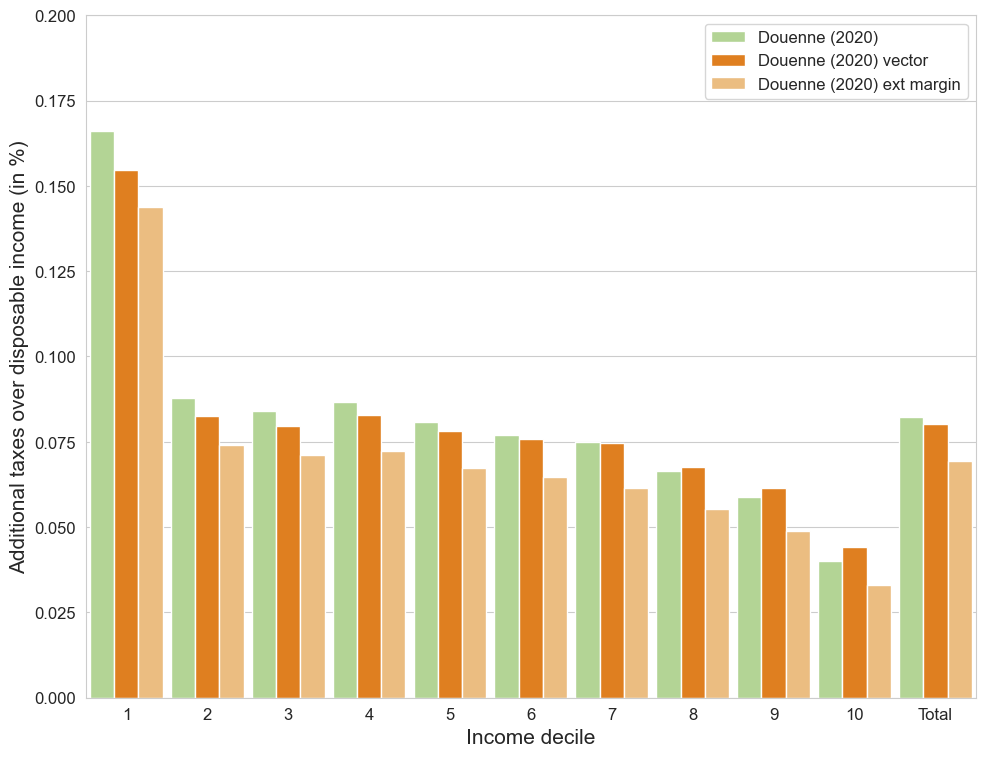

In [7]:
graph_effort_rate(to_graph_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

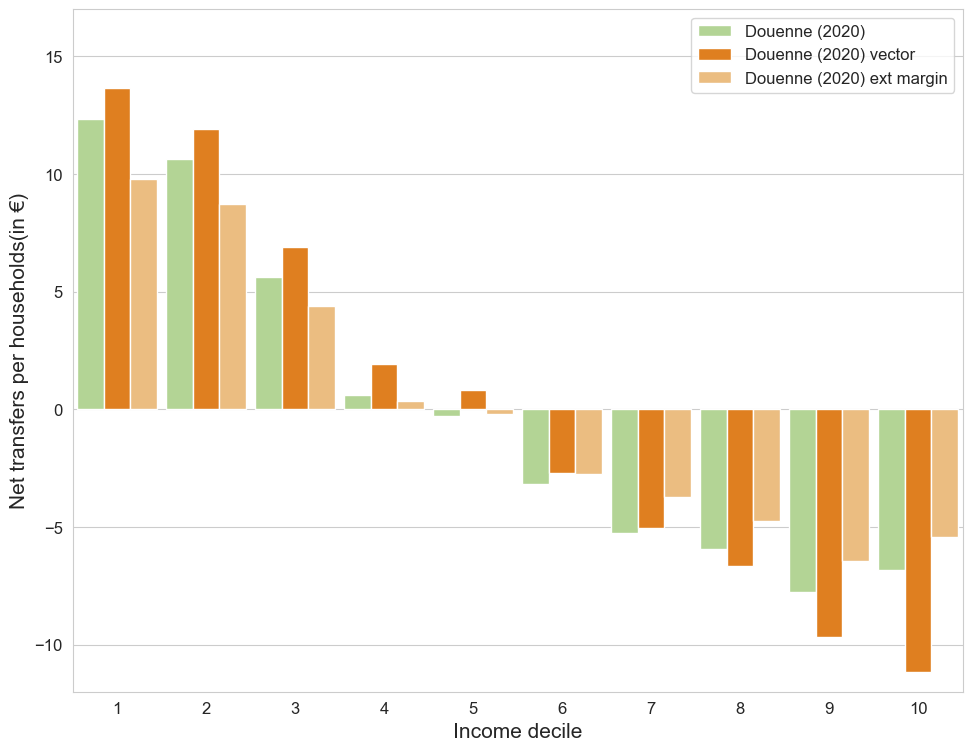

In [8]:
graph_net_transfers(to_graph_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

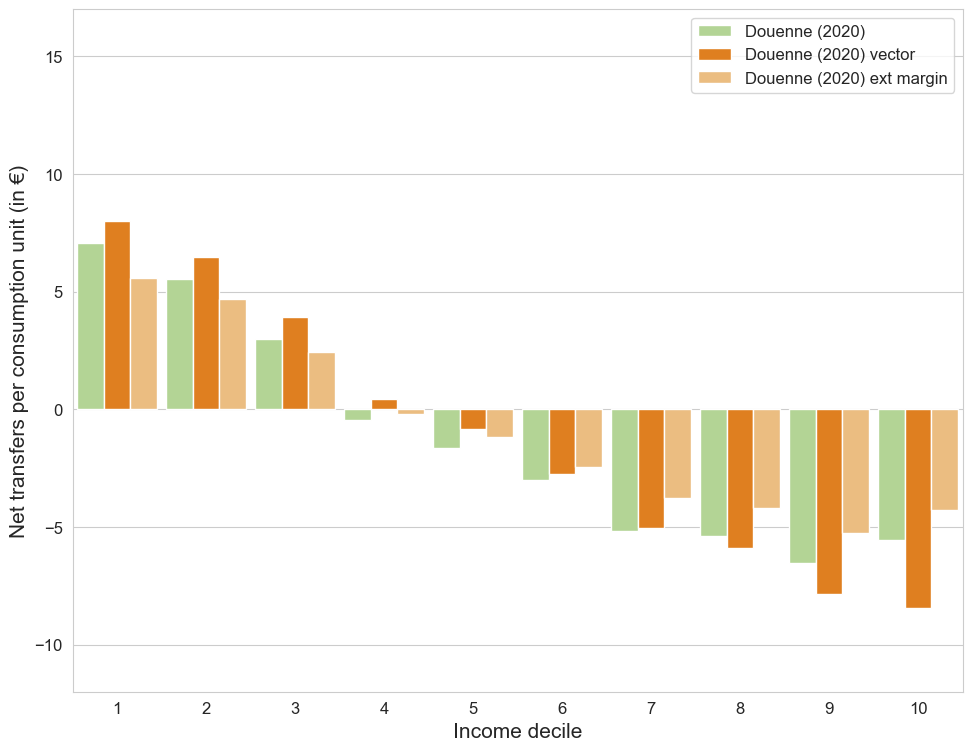

In [9]:
graph_net_transfers_uc(to_graph_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

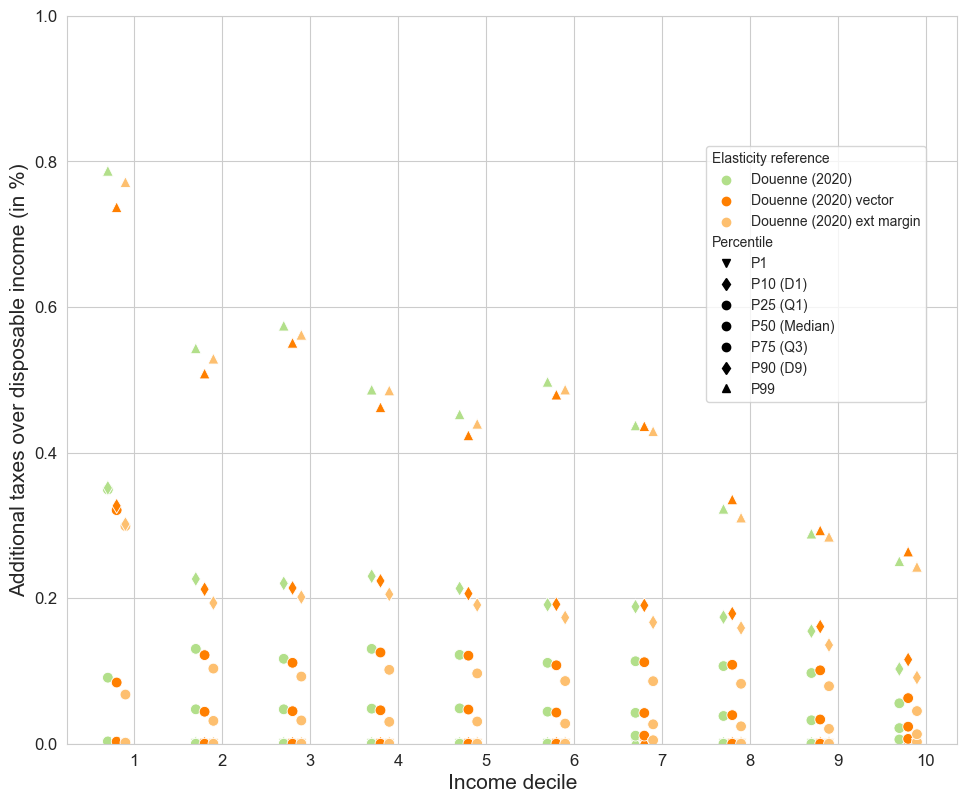

In [10]:
boxplot_effort_rate(menages_reform_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

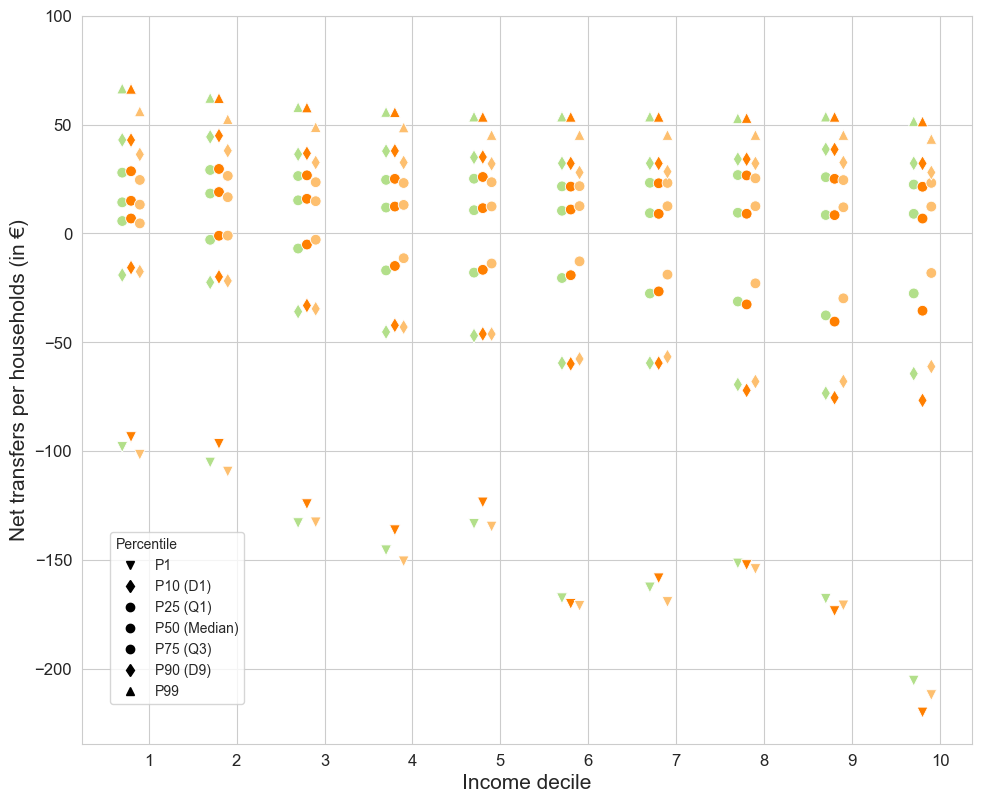

In [11]:
boxplot_net_transfers(menages_reform_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

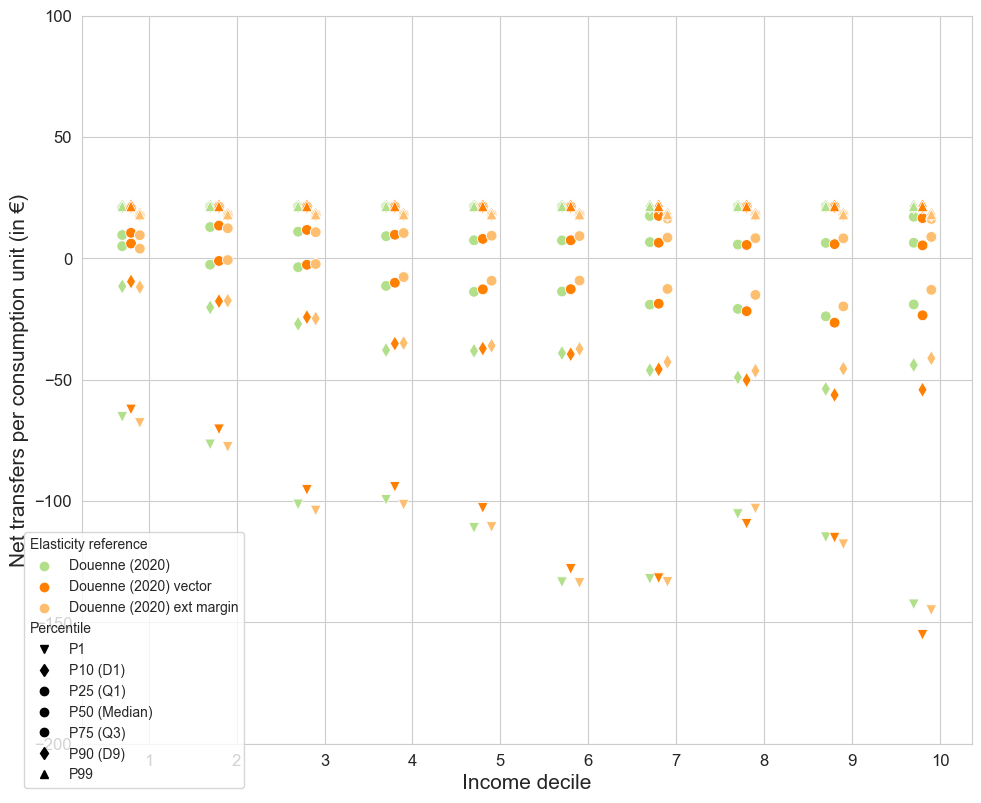

In [12]:
boxplot_net_transfers_uc(menages_reform_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

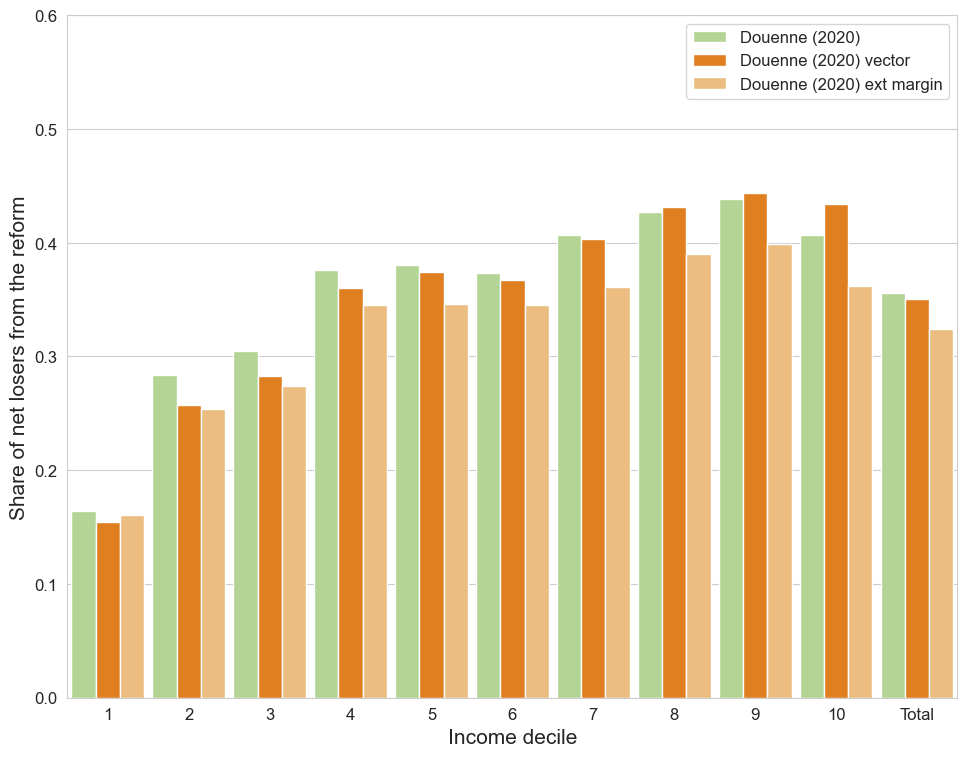

In [13]:
graph_winners_losers(to_graph_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

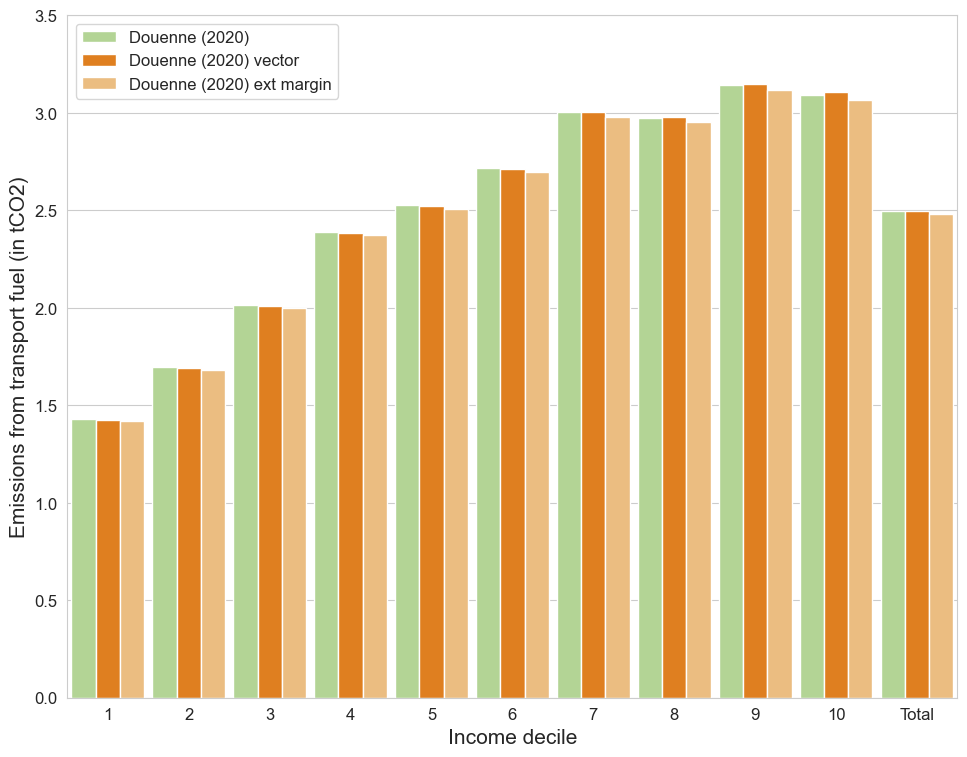

In [14]:
graph_CO2_emissions(to_graph_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

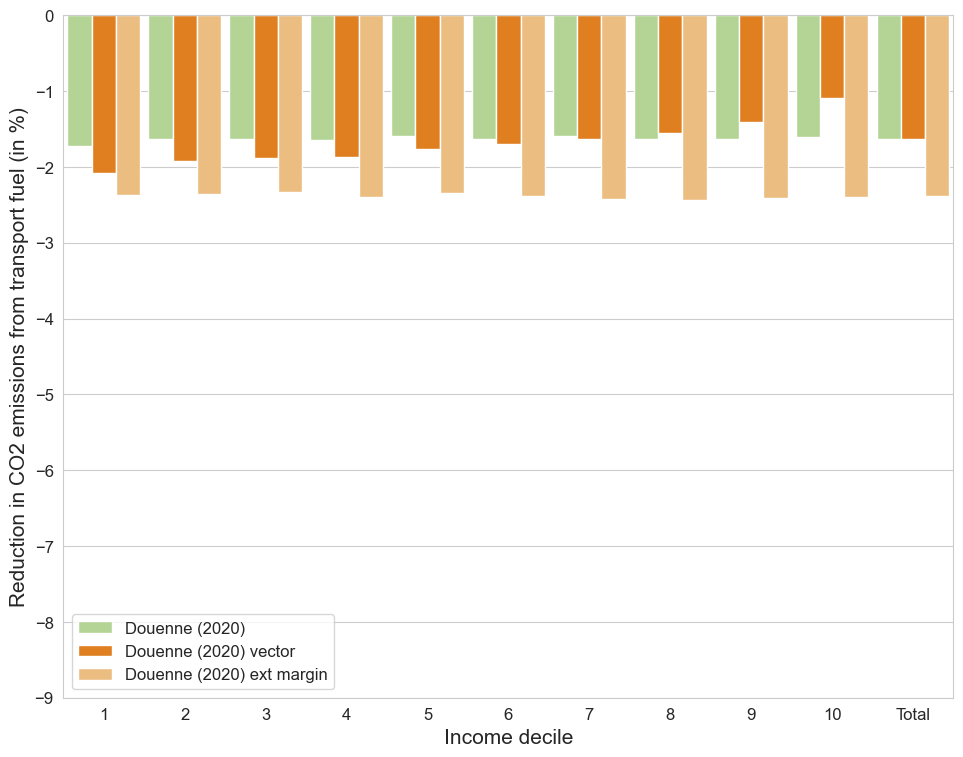

In [15]:
graph_delta_CO2(to_graph_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

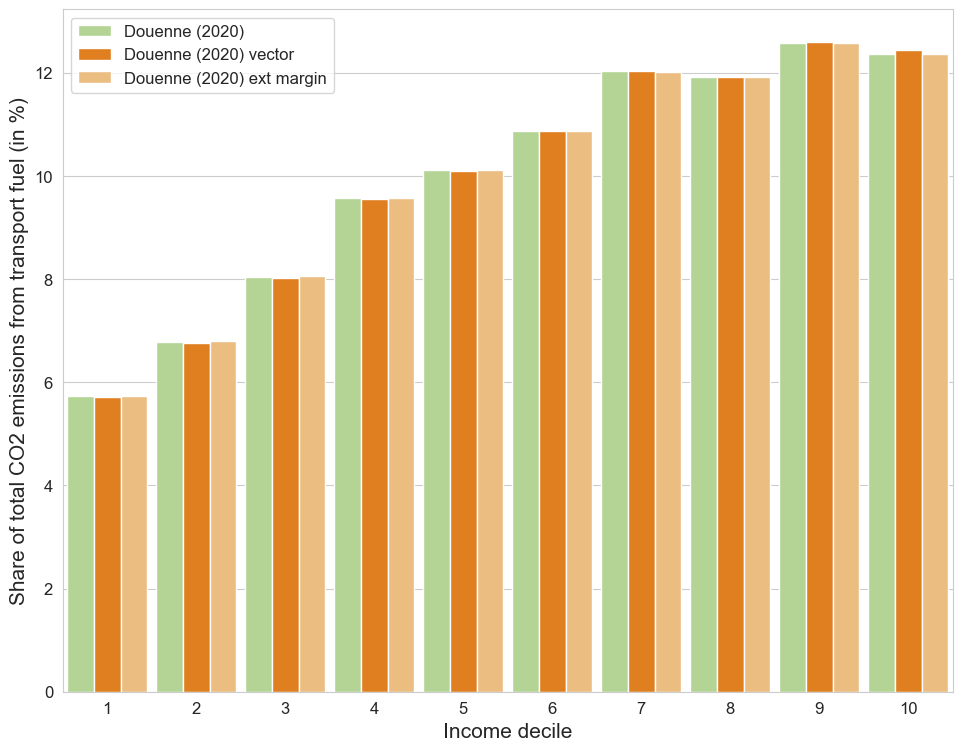

In [16]:
graph_share_co2_emissions(df_sum_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

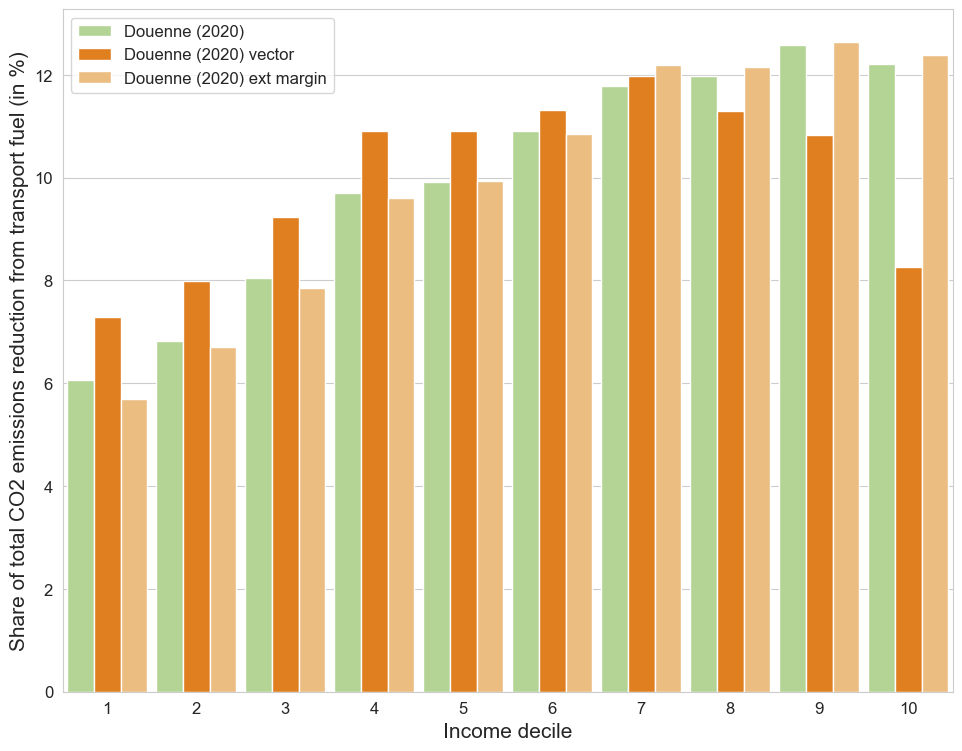

In [17]:
graph_share_emissions_reduction(df_sum_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)

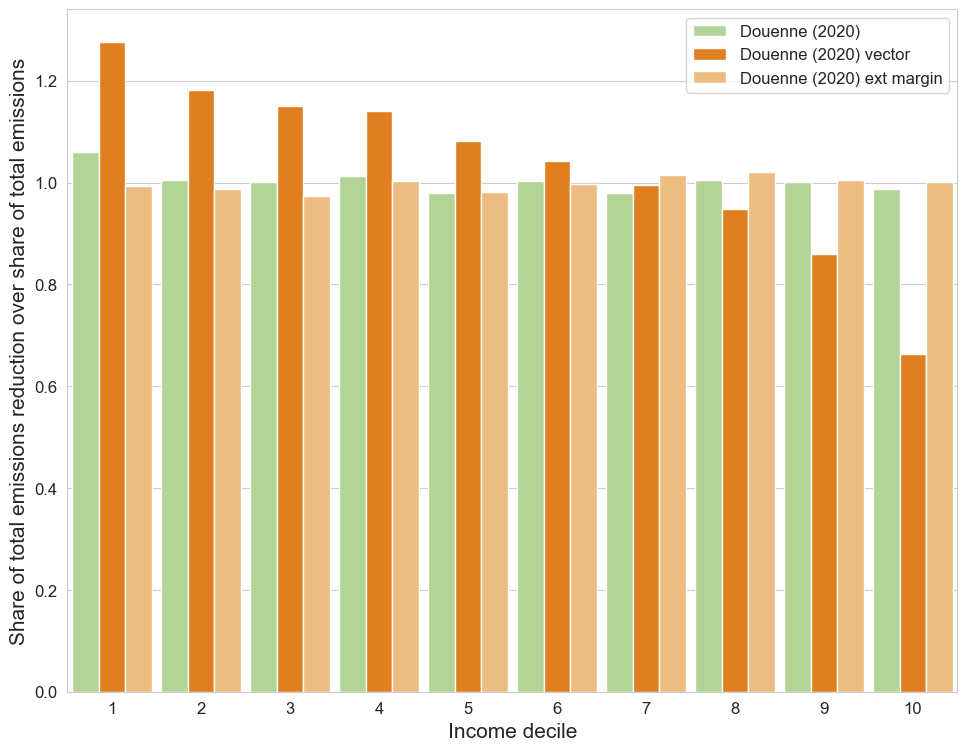

In [18]:
graph_ratio_emissions_reduction(df_sum_douenne_only,carbon_tax_rv,elas_ext= True, elas_vect=False,bonus_cheques_uc=True)